## Creating a 1700 calorie daily meal planner

### Introduction
Like most people, I'm always watching my weight! I've found over the past few years that I can gradually lose weight or maintain my weight if I stick to a daily calorie intake of 1700.

The goal of this project is to analyse the data from the Epicurious recipe dataset with a view to creating daily meal planners (breakfast, lunch and dinner) that don't exceed 1700 calories in total.

In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
print(os.listdir("../input")) # list files in directory

['full_format_recipes.json', 'epi_r.csv', 'utils.py', 'recipe.py']


We'll just be concentrating on the data in full_format_recipes.json so let's read that into a dataframe

In [36]:
recipes = pd.read_json('../input/full_format_recipes.json')

Let's do some initial exploration of the data

In [37]:
recipes.head()

,calories,categories,date,desc,directions,fat,ingredients,protein,rating,sodium,title
0,426.0,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",2006-09-01 04:00:00,None,"[1. Place the stock, lentils, celery, carrot, ...",7.0,"[4 cups low-sodium vegetable or chicken stock,...",30.0,2.500,559.0,"Lentil, Apple, and Turkey Wrap"
1,403.0,"[Food Processor, Onion, Pork, Bake, Bastille D...",2004-08-20 04:00:00,This uses the same ingredients found in boudin...,[Combine first 9 ingredients in heavy medium s...,23.0,"[1 1/2 cups whipping cream, 2 medium onions, c...",18.0,4.375,1439.0,Boudin Blanc Terrine with Red Onion Confit
2,165.0,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",2004-08-20 04:00:00,None,[In a large heavy saucepan cook diced fennel a...,7.0,"[1 fennel bulb (sometimes called anise), stalk...",6.0,3.750,165.0,Potato and Fennel Soup Hodge
3,NaN,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",2009-03-27 04:00:00,The Sicilian-style tomato sauce has tons of Me...,[Heat oil in heavy large skillet over medium-h...,NaN,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN,5.000,NaN,Mahi-Mahi in Tomato Olive Sauce
4,547.0,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",2004-08-20 04:00:00,None,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,"[1 12-ounce package frozen spinach soufflé, th...",20.0,3.125,452.0,Spinach Noodle Casserole


In [38]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20130 entries, 0 to 20129
Data columns (total 11 columns):
calories       15976 non-null float64
categories     20111 non-null object
date           20111 non-null datetime64[ns]
desc           13495 non-null object
directions     20111 non-null object
fat            15908 non-null float64
ingredients    20111 non-null object
protein        15929 non-null float64
rating         20100 non-null float64
sodium         15974 non-null float64
title          20111 non-null object
dtypes: datetime64[ns](1), float64(5), object(5)
memory usage: 1.7+ MB


In [39]:
for col in recipes.columns:
    print(col, type(recipes[col][1]))                                                            

calories <class 'numpy.float64'>
categories <class 'list'>
date <class 'pandas._libs.tslibs.timestamps.Timestamp'>
desc <class 'str'>
directions <class 'list'>
fat <class 'numpy.float64'>
ingredients <class 'list'>
protein <class 'numpy.float64'>
rating <class 'numpy.float64'>
sodium <class 'numpy.float64'>
title <class 'str'>


The data consists of 20,130 entries and 11 columns:
- calories (float))
- categories (list) - keywords of recipe
- data (datetime)
- desc (string) - description of recipe
- directions (list) - list of steps of the recipe
- fat (float) - fat content
- ingredients (list)
- protein (float) - protein content
- rating (float) - average rating of recipe
- sodium (float) - sodium (salt) content
- title (string) - name of recipe

To get a daily meal planner we will need to create a new 'meal_type' column and assign each recipe a 'Breakfast', 'Lunch' or 'Dinner' category. Since the current data doesn't provide such information we will have to search the categories for keywords that can help us decide which meal type it should belong to.

Before we get to that, let's deal with any missing data by removing any rows with null values in either the 'calories' or 'title' columns, since these are 2 pieces of data that we will definitely need for the project and which are difficult to replace.

In [40]:
recipes_clean = recipes.dropna(subset=['title','calories']).reset_index(drop=True) # remove rows with null values in 2 columns

In [41]:
recipes_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15976 entries, 0 to 15975
Data columns (total 11 columns):
calories       15976 non-null float64
categories     15976 non-null object
date           15976 non-null datetime64[ns]
desc           10643 non-null object
directions     15976 non-null object
fat            15908 non-null float64
ingredients    15976 non-null object
protein        15929 non-null float64
rating         15969 non-null float64
sodium         15974 non-null float64
title          15976 non-null object
dtypes: datetime64[ns](1), float64(5), object(5)
memory usage: 1.3+ MB


Let's look at the keywords/tags in the 'categories' column:

In [42]:
# create a string that combines all keywords from the 'categories' column:
recipes_clean['categories_string'] = recipes_clean['categories'].apply(','.join).str.lower() # a new column creating string of keywords
combined_cats = recipes_clean['categories_string'].str.cat(sep=',') # combine all keywords from new column

# create a dictionary of keywords with the number of times they occur
from collections import Counter
cat_counter= Counter(combined_cats.split(","))

# print the top 300 keywords
print(cat_counter.most_common(300))

[('bon appétit', 7400), ('peanut free', 6727), ('soy free', 6508), ('gourmet', 5701), ('tree nut free', 5622), ('vegetarian', 5538), ('kosher', 4991), ('pescatarian', 4882), ('quick & easy', 4216), ('wheat/gluten-free', 3907), ('bake', 3725), ('summer', 3257), ('dessert', 2958), ('winter', 2586), ('side', 2563), ('fall', 2504), ('dairy free', 2496), ('no sugar added', 2418), ('kidney friendly', 1929), ('sugar conscious', 1917), ('dinner', 1899), ('onion', 1848), ('milk/cream', 1713), ('sauté', 1689), ('tomato', 1682), ('vegetable', 1675), ('fruit', 1594), ('vegan', 1461), ('egg', 1434), ('herb', 1399), ('kid-friendly', 1362), ('garlic', 1344), ('spring', 1334), ('healthy', 1265), ('dairy', 1242), ('thanksgiving', 1229), ('salad', 1165), ('cheese', 1058), ('chicken', 1049), ('appetizer', 1047), ('roast', 1042), ('no-cook', 1025), ('soup/stew', 940), ('lunch', 939), ('chill', 937), ('sauce', 928), ('potato', 920), ('ginger', 914), ('lemon', 901), ('cocktail party', 886), ('christmas', 84

From the list above we can see that we have the keywords 'dinner', 'lunch' and 'breakfast', which we can use to categorize recipes.

In [43]:
print('Breakfast: ', cat_counter['breakfast'])
print('Lunch: ', cat_counter['lunch'])
print('Dinner: ', cat_counter['dinner'])

Breakfast:  541
Lunch:  939
Dinner:  1899


Looking through the list of categories there are some that we will not want to include in our recipe planner. These are 'side', 'appetizer', 'sauce', 'jam or jelly', 'drink', 'condiment/spread', 'snack', 'salad dressing' and 'stuffing/dressing'. Let's remove these recipes from the database.

In [44]:
drop_list = ['side','appetizer', 'sauce', 'jam or jelly', 'drink', 'condiment/spread','snack', 'salad dressing', 'stuffing/dressing']

for tag in drop_list:
    recipes_clean = recipes_clean.drop(recipes_clean[recipes_clean['categories_string'].str.contains(tag) == True].index)

Let's create new columns for each meal type. Each entry will be True or False depending on whether that meal type tag appears in the 'categories' columns.

In [45]:
meal_type = ['breakfast', 'lunch', 'dinner']
# create a new column for each meal type
for meal in meal_type:
    recipes_clean[meal] = recipes_clean['categories_string'].str.contains(meal)

In [46]:
# calculate how many recipes are tagged both Breakfast and Lunch
len(recipes_clean[(recipes_clean['lunch'] == True) & (recipes_clean['breakfast'] == True)])

27

It looks like there are recipes that are tagged both 'Breakfast' and 'Lunch'. Let's remove these rows along with any other recipes with multiple meal_type tags:

In [47]:
recipes_clean = recipes_clean.drop(recipes_clean[(recipes_clean['lunch'] == True) & 
                                   (recipes_clean['dinner'] == True)].index)
recipes_clean = recipes_clean.drop(recipes_clean[(recipes_clean['lunch'] == True) & 
                                   (recipes_clean['breakfast'] == True)].index)
recipes_clean = recipes_clean.drop(recipes_clean[(recipes_clean['breakfast'] == True) & 
                                   (recipes_clean['dinner'] == True)].index)
recipes_clean = recipes_clean.drop(recipes_clean[(recipes_clean['lunch'] == True) & 
                                   (recipes_clean['dinner'] == True) &
                                                (recipes_clean['breakfast'] == True)].index)

In [48]:
# recalculate how many recipes of each meal type we are left with
for meal in meal_type:
    print(meal, ": ", recipes_clean[meal].sum())

breakfast :  400
lunch :  371
dinner :  1210


Let's start investigating the spread of calories in each of our meal types.

In [49]:
print(recipes_clean['calories'].value_counts().sort_index(ascending=False).head(10)) # top 10 recipes by calorie count
print(recipes_clean['calories'].value_counts().sort_index(ascending=False).tail(10)) # bottom 10 recipes by calorie count

30111218.0    1
29997918.0    1
13062948.0    1
4518216.0     1
4157357.0     2
3358273.0     1
3358029.0     1
54512.0       1
24117.0       2
22312.0       3
Name: calories, dtype: int64
9.0     4
8.0     5
7.0     2
6.0     8
5.0     1
4.0     9
3.0     6
2.0     7
1.0     3
0.0    13
Name: calories, dtype: int64


It seems we have some outlying recipes with extremely high and extremely low calorie count. Let's limit out recipes to only those that lie in the calorie range between 200 and 1300.

In [50]:
recipes_clean = recipes_clean[recipes_clean['calories'].between(200,1300)]

Let's visualize the spread of calories in our possible meals within this new range:

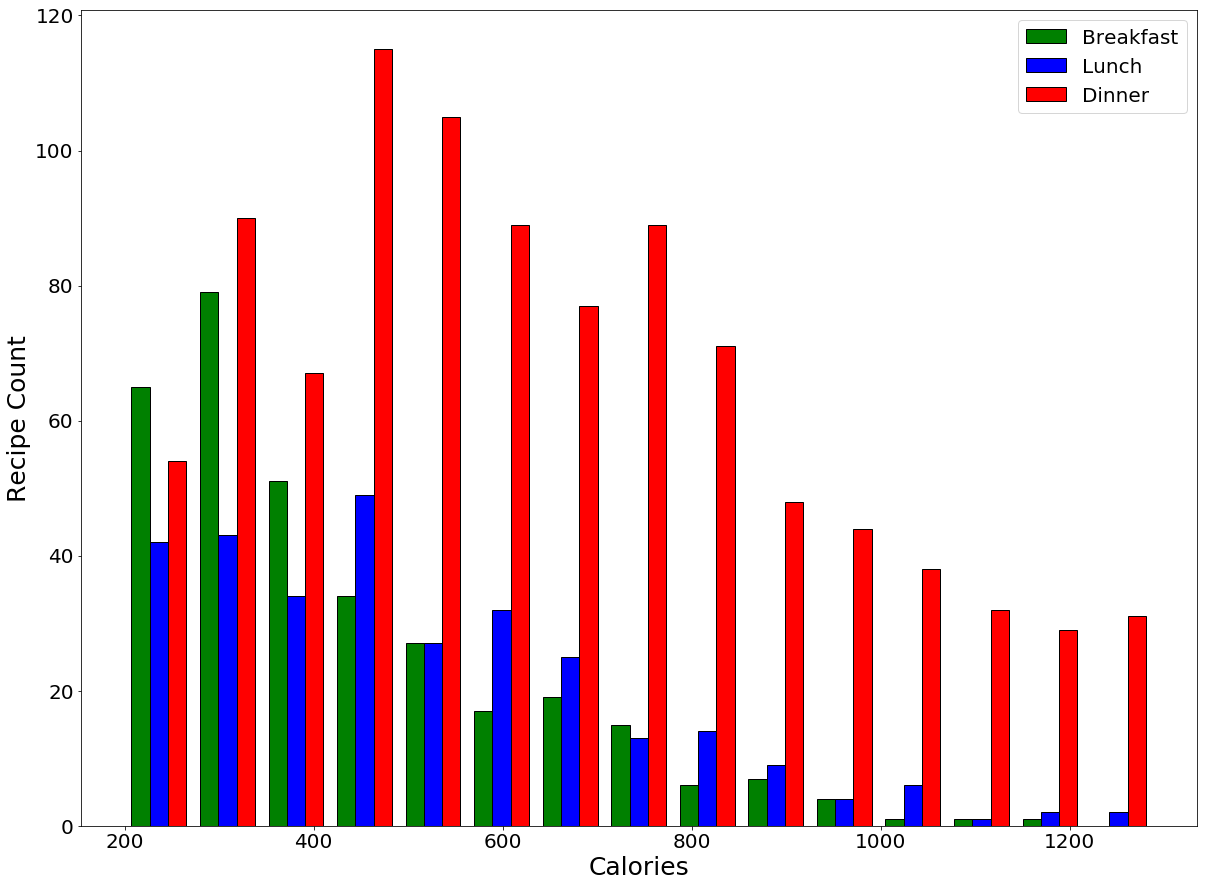

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

breakfast_cal = recipes_clean[recipes_clean['breakfast'] == True]['calories']
lunch_cal = recipes_clean[recipes_clean['lunch'] == True]['calories']
dinner_cal = recipes_clean[recipes_clean['dinner'] == True]['calories']

fig, ax = plt.subplots(figsize=(20,15))

ax.hist(x=[breakfast_cal, lunch_cal, dinner_cal], bins=15, color=['green', 'blue', 'red'],label=['Breakfast', 'Lunch', 'Dinner'],
        edgecolor='black')
ax.legend(prop={'size':20})
ax.set_xlabel('Calories', fontsize = 25)
ax.set_ylabel('Recipe Count', fontsize = 25)
ax.tick_params(axis='both',labelsize=20)

It seems mosts of the breakfasts have calories of 400 or less, most lunches are 600 or less and most dinners are 800 or less.

Let's create separate databases for each meal type but restricted to certain calorie range: (200,400) for breakfast, (300,600) for lunch and (400,800) for dinner

In [52]:
# create individual databases depending on meal type:
recipes_breakfast = recipes_clean[(recipes_clean['breakfast'] == True) & (recipes_clean['calories'].between(200,400))]
recipes_lunch = recipes_clean[(recipes_clean['lunch'] == True) & (recipes_clean['calories'].between(300,600))]
recipes_dinner = recipes_clean[(recipes_clean['dinner'] == True) & (recipes_clean['calories'].between(400,800))]

print(len(recipes_breakfast), len(recipes_lunch), len(recipes_dinner)) # print out count of recipes left

187 154 519


We are now in a position to create a random daily meal planner based on a total daily calorie count of no more than 1700 calories. We will pick a random breakfast and lunch recipe from the databases and then pick a random dinner recipe subject to our calorie constraint.

In [57]:
# random breakfast recipe
breakfast = recipes_breakfast.sample(1)
breakfast_cal = breakfast.iat[0,0] # breakfast calories

# random lunch recipe
lunch = recipes_lunch.sample(1)
lunch_cal = lunch.iat[0,0] # lunch calories

balance = 1700 - breakfast_cal - lunch_cal

# random dinner recipe subject to calorie constraint
dinner = recipes_dinner[recipes_dinner['calories'] < balance].sample(1)
dinner_cal = dinner.iat[0,0] # dinner calories

total_cal = breakfast_cal + lunch_cal + dinner_cal


In [58]:
# create database of daily meal planner by concatenation
pd.concat([breakfast, lunch, dinner],axis=0)

,calories,categories,date,desc,directions,fat,ingredients,protein,rating,sodium,title,categories_string,breakfast,lunch,dinner
12129,273.0,"[Bread, Breakfast, Brunch, Bake, Raisin, Gourmet]",2004-08-20 04:00:00,None,"[Sift together flour, baking powder, and salt ...",8.0,"[3 3/4 cups all-purpose flour, 1 1/2 tablespoo...",6.0,3.125,295.0,Raisin Scones,"bread,breakfast,brunch,bake,raisin,gourmet",True,False,False
3610,527.0,"[Soup/Stew, Bean, Onion, Potato, Kid-Friendly,...",2015-02-18 04:00:00,"For rave-worthy soups, skip the store-bought s...","[Tie oregano, rosemary, and bay leaves togethe...",22.0,"[3 sprigs oregano, 3 sprigs rosemary, 2 bay le...",23.0,5.000,943.0,Kale Minestrone with Pistou,"soup/stew,bean,onion,potato,kid-friendly,low c...",False,True,False
11471,797.0,"[Garlic, Pasta, Vegetarian, Kid-Friendly, Dinn...",2004-08-20 04:00:00,None,[In a 6- to 7-quart kettle bring about 5 quart...,38.0,"[1 pound penne or other tubular pasta, 1 pound...",24.0,3.750,496.0,Pasta with Asparagus Pesto,"garlic,pasta,vegetarian,kid-friendly,dinner,pa...",False,False,True


In [59]:
print("Total Calories: ", total_cal)

Total Calories:  1597.0


## Conclusion

To get out daily meal planner of no more than 1700 calories in total we took the following steps:
1. Initial exploration of the data in full_format_recipes.json
2. Cleaning the data by dropping rows with missing data ('title' and 'calories')
3. Exploring the 'categories' column for relevant keywords
4. Dropping rows with keywords which suggested the recipe was not suitable for breakfast, lunch or dinner
5. Creating new columns based on the 'breakfast', 'lunch' or 'dinner' keywords
6. Exploring the range of calories  in the database and creating meal type databases based on calorie ranges
7. Selecting random meals from these meal type databases subject to our calorie restrictions
